In [1]:
using PETScBinaryIO
using Makie
using SparseArrays
using LinearAlgebra
using BALUtils
using Colors
using Statistics
using Optim
using HDF5

┌ Info: Recompiling stale cache file /Users/tristan/.julia/compiled/v1.1/BALUtils/NXPkz.ji for BALUtils [0905a5ce-360c-11e9-2081-2954d989a4fb]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/tristan/.julia/compiled/v1.1/HDF5/L7Dga.ji for HDF5 [f67ccb44-e63f-5c2f-98bd-6dc0ccc4ba2f]
└ @ Base loading.jl:1184


In [2]:
# code for showing values nicely
struct StringWrap
    s :: AbstractString
end
Base.show(io :: IO, s :: StringWrap) = print(io, s.s)
macro display(exs...)
    blk = Expr(:block)
    for ex in exs
        push!(blk.args, :(display(StringWrap($(sprint(Base.show_unquoted,ex)*" = ")))))
        push!(blk.args, :(display(begin value=$(esc(ex)) end)))
    end
    isempty(exs) || push!(blk.args, :value)
    return blk
end

@display (macro with 1 method)

In [3]:
function compute_eigs(S, dscale, ba)
    D = Diagonal(dscale[1:length(ba.cameras)*9])
    F = svd(inv(D) * Array(S) * inv(D))
    F = svd(Array(S))
    # we assume cameras come first (true if running on one process)
    evs = mapslices(x -> x .* dscale[1:length(ba.cameras)*9], F.U, dims=1)
    evs, F.S
end

compute_eigs (generic function with 1 method)

In [204]:
index = 1
ba_dubrovnik = read_bal("../bal-data/dubrovnik/problem-16-22106-pre.txt")
S = readpetsc("../ba-tao/dubrovnik-16-SP.petsc")[1]
dscale = readpetsc("../ba-tao/dubrovnik-16-scale.petsc")[1]
poses_dubrovnik = reshape(readpetsc("../ba-tao/dubrovnik-16-scaled-solution.petsc")[index][1:length(ba_dubrovnik.cameras)*9], 9, :)
evecs, evals = compute_eigs(S, dscale, ba_dubrovnik);

In [5]:
index = 1
ba = read_bal("../bal-data/trafalgar/problem-21-11315-pre.txt")
S = readpetsc("../ba-tao/trafalgar-21-SP.petsc")[1]
dscale = readpetsc("../ba-tao/trafalgar-21-scale.petsc")[1];
evecs, evals = compute_eigs(S, dscale, ba);

In [4]:
index = 1
ba = read_bal("../bal-data/ladybug/problem-49-7776-pre.txt")
S = readpetsc("../ba-tao/ladybug-49-SP.petsc")[index]
H = readpetsc("../ba-tao/ladybug-49-H.petsc")[index]
dscale = readpetsc("../ba-tao/ladybug-49-scale.petsc")[index];
dscale = ones(length(ba.cameras)*9)
poses = reshape(readpetsc("../ba-tao/ladybug-49-solution.petsc")[index][1:length(ba.cameras)*9], 9, :)
evecs, evals = compute_eigs(S, dscale, ba);

In [82]:
l = length(ba.cameras)
rinds = (((1:l*9) .- 1) .% 9) .<= 3
tinds = 4 .<= (((1:l*9) .- 1) .% 9) .<= 6
iinds = 7 .<= (((1:l*9) .- 1) .% 9) .<= 9
trange = 4:6
rrange = 1:3
irange = 7:9
;

In [28]:
function draw_change(ba, eigs, num, range, scale)
    s = Scene()
    poses = hcat(map(x -> [x[i] for i in 1:length(x)], pose.(ba.cameras))...)
    scatter!(s, poses[4,:], poses[5,:], poses[6,:], markersize=0.01, transparency=true)
    cmap = distinguishable_colors(num, lchoices=0:10:80)
    for i in 1:num
        es = reshape(eigs[1][:, end-(i-1)], 9, :)
        poses_moved = poses[trange,:] .+ es[range] .* scale
        paired = reshape(vcat(poses, poses_moved), 3, :)
        linesegments!(s, paired[1,:], paired[2,:], paired[3,:], transparency=true, color=cmap[i])
    end
    s
end
draw_translations(ba, eigs, num) = draw_change(ba, eigs, num, trange, 10000)
draw_rotations(ba, eigs, num) = draw_change(ba, eigs, num, rrange, 100)

function draw_diff!(scene :: Scene, initial :: Array, change :: Array, scale :: Float64; kwargs...)
    moved = initial .+ change * scale
    paired = reshape(vcat(initial, moved), size(initial,1), :)
    linesegments!(scene, paired[1,:], paired[2,:], paired[3,:], transparency=true; kwargs...)
end

draw_diff!(initial :: Array, change :: Array, scale :: Float64; kwargs...) = draw_diff!(AbstractPlotting.current_scene(), initial, change, scale; kwargs...)

draw_diff! (generic function with 2 methods)

In [200]:
l = length(ba.cameras)

anullspace = evecs[:,(evals .< 1e-4)]
@display evals

function linear_rotation(poses, axis, center)
    l = size(poses, 2)
    rot = mapslices(x -> cross(axis, x), poses[trange,:] .- center, dims=1)
    vcat(
        hcat(map(i -> axis .* atan(norm(rot[:,i]), norm(poses[trange,i] .- center)), 1:l)...),
        rot,
        zeros(3, l)
    )
end

function nullspace_matrix(poses)
    l = size(poses, 2)
    
    x_trans = vcat(zeros(3, l), ones(1, l), zeros(5, l))
    y_trans = vcat(zeros(4, l), ones(1, l), zeros(4, l))
    z_trans = vcat(zeros(5, l), ones(1, l), zeros(3, l))

    center = mapslices(mean, poses[trange,:], dims=2)[:]

    scaling = vcat(poses[trange,:] .- center, zeros(6, l))


    x_rot = linear_rotation(poses, [1,0,0], center)
    y_rot = linear_rotation(poses, [0,1,0], center)
    z_rot = linear_rotation(poses, [0,0,1], center)


    hcat(x_trans[:],
         y_trans[:],
         z_trans[:],
         scaling[:],
         x_rot[:],
         y_rot[:],
         z_rot[:],
        )
end

m = hcat(nullspace_matrix(poses),  reshape(anullspace, 9*l, :))

Q,R = qr(m)
@display Q
@display R[:,8:end]
;

evals = 

144-element Array{Float64,1}:
 3.338768951584677     
 3.2658075397776316    
 3.2384597751243906    
 3.1468731964809202    
 2.882638112555356     
 2.760587271131903     
 2.7087272679437575    
 2.6583837346652275    
 2.63527965833679      
 2.6239539774332536    
 2.3895850245165464    
 2.1965524868214987    
 1.9593018126622275    
 ⋮                     
 0.0015077104112845752 
 0.0014907979278840848 
 0.0013814984779342038 
 0.0009472267323473447 
 0.0001595944013503776 
 1.1059499220466227e-15
 1.07475011379329e-15  
 8.690436961783649e-16 
 7.045451627074128e-16 
 6.976076839863527e-16 
 4.785972504015204e-16 
 4.4039278812149596e-17

DimensionMismatch: DimensionMismatch("array size 1008 must be divisible by the product of the new dimensions (441, Colon())")

In [101]:
# Test if  
# QT JTJ Q == 0?
# JTJ * Q == 0?
D = Diagonal(dscale[1:l*9][tinds])
x = inv(D) * S[tinds,tinds] * inv(D)
@display maximum(abs.(nonzeros(x)))
#Q[tinds, 1:7]' * (D * S * D)[tinds,tinds] * Q[tinds, 1:7]
U, es, _ = svd(Array(x))
@display es
Q[tinds,1:7]' * x * Q[tinds,1:7]

maximum(abs.(nonzeros(x))) = 

3.967362440295104e8

es = 

147-element Array{Float64,1}:
  7.547763590205106e8 
  1.2991125374400033e8
  1.1554925357029489e8
  1.0150333905808961e8
  9.325074907874103e7 
  8.598033963644807e7 
  8.183028226314688e7 
  7.63801841847291e7  
  7.161033266023926e7 
  7.075010669059548e7 
  6.465967300718803e7 
  6.172910111618173e7 
  6.041934538799502e7 
  ⋮                   
 11.641753229254466   
 11.269792998535726   
 11.198960356909977   
  9.784874563535109   
  8.094781046723618   
  6.248821205495701   
  5.2249065616385115  
  4.1814885461189455  
  3.660622932421735   
  2.2358523611127494  
  0.8509918694424976  
  0.4188249500976114  

7×7 Array{Float64,2}:
 0.0      0.0             0.0          …      0.0             0.0        
 0.0    681.956       50854.6             -8713.99         8116.1        
 0.0  50854.6             4.92394e6          -4.72303e5       7.35702e5  
 0.0      3.0883e-13      2.99007e-11        -2.86843e-12     4.46761e-12
 0.0   6937.65            5.87501e5          -2.59959e6       1.68645e7  
 0.0  -8713.99           -4.72303e5    …      1.12858e6      -3.31746e6  
 0.0   8116.1             7.35702e5          -3.31746e6       2.5969e7   

poses = 

9×49 Array{Float64,2}:
   0.0157415      0.0159773      0.0143351    …    0.0134076      0.00526132 
  -0.0127909     -0.0252245     -0.00281315        0.0257303     -1.23654    
  -0.00440085    -0.00940014    -0.00640993       -0.000534617    0.0266735  
  -0.0340938     -0.00856677    -0.0365177        -0.146072      -3.63692    
  -0.107514      -0.12188       -0.0983219        -0.0129378     -0.0281637  
   1.12022        0.719013       1.31422      …    3.36297        0.962054   
 399.752        402.018        399.452           395.273        403.856      
  -3.17706e-7    -3.78048e-7    -3.17118e-7       -2.88581e-7     1.45652e-8 
   5.88205e-13    9.30743e-13    5.49809e-13       5.73277e-13    3.77593e-14

poses_ = 

3×49 Array{Float64,2}:
 -0.0340938  -0.00856677  -0.0365177  …  -3.49388    -0.146072   -3.63692  
 -0.107514   -0.12188     -0.0983219     -0.0358653  -0.0129378  -0.0281637
  1.12022     0.719013     1.31422        0.981607    3.36297     0.962054 

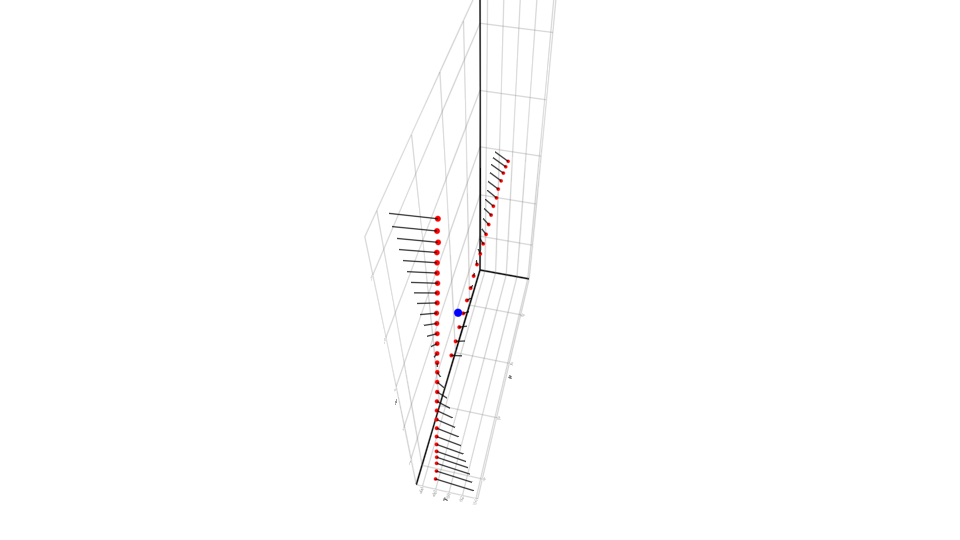

In [107]:
es = reshape(Q[:,9], 9, :)

poses_ = hcat(Array.(pose.(ba.cameras))...)
@display poses
@display poses_

s = Scene()
scatter!(s, poses[4,:], poses[5,:], poses[6,:], markersize=0.05, transparency=true, color=:red)
#scatter!(s, poses_[1,:], poses_[2,:], poses_[3,:], markersize=0.05, transparency=true, color=:green)
scatter!(s, [center[1]], [center[2]], [center[3]], margersize=0.2, color=:blue, transparency=true)

# draw_diff!(s, poses, x_rot[1:3,:] * qr_.R[5,6], 1, color=:blue)

#draw_diff!(s, poses, y_rot[trange,:], 0.2, color=:red)
#draw_diff!(s, poses[trange,:], es[rrange,:], 5.0, color=:red)
draw_diff!(s, poses[trange,:], es[trange,:], 5.0, color=:black)

In [121]:
function normalize_sign(x)
    if x[1] < 0
        x
    else
        -x
    end
end
axis = mean(mapslices(x -> normalize_sign(normalize(cross(es[trange,1], x))), es[trange,2:end], dims=1), dims=2)

3×1 Array{Float64,2}:
 -0.1933643074627202  
  0.7049639166962622  
 -0.008363279826220217

mapslices((x->begin
            #= In[126]:2 =#
            normalize_sign(normalize(cross(es[trange, 1], x)))
        end), es[trange, 2:end], dims=1) = 

3×48 Array{Float64,2}:
 -0.2838    -0.16948     -0.156955    …  -0.0847777  -0.225777    -0.0810488
  0.95877    0.985522     0.987582        0.996222    0.974167     0.99652  
 -0.014762   0.00471642   0.00682197      0.0188494  -0.00481618   0.0194659

axis .- mapslices((x->begin
                #= In[126]:3 =#
                normalize_sign(normalize(cross(es[trange, 1], x)))
            end), es[trange, 2:end], dims=1) = 

3×48 Array{Float64,2}:
  0.090436    -0.0238846  -0.0364098  …  -0.108587    0.032413   -0.112315 
 -0.253806    -0.280558   -0.282618      -0.291258   -0.269203   -0.291556 
  0.00639869  -0.0130797  -0.0151852     -0.0272127  -0.0035471  -0.0278292

147×7 Array{Float64,2}:
 -0.142857   0.0        0.0        1.11022e-16  …   0.0198025    -0.00128611 
  0.0       -0.142857   0.0       -1.35525e-20      0.000339238  -0.0916778  
  0.0        0.0       -0.142857  -8.67362e-19     -0.0661636     0.00143282 
 -0.142857   0.0        0.0       -1.73472e-18     -0.0101438    -0.00211496 
  0.0       -0.142857   0.0       -1.35525e-20     -0.000173774  -0.0938937  
  0.0        0.0       -0.142857  -8.67362e-19  …  -0.0680506     0.00145943 
 -0.142857   0.0        0.0       -1.73472e-18      0.0342822    -0.000653851
  0.0       -0.142857   0.0       -1.35525e-20      0.000587289  -0.091629   
  0.0        0.0       -0.142857  -8.67362e-19     -0.0659944     0.00143841 
 -0.142857   0.0        0.0       -1.73472e-18      0.00498175   -0.0016304  
  0.0       -0.142857   0.0       -1.35525e-20  …   8.53423e-5   -0.0924146  
  0.0        0.0       -0.142857  -8.67362e-19     -0.0668377     0.00144098 
 -0.142857   0.0        0.0       -1.734

3.4500806027156536

"Solution"

"Old center"

3-element Array{Float64,1}:
 -0.9206721076162717
 -0.0992228872411215
  0.8549165375497423

"Dot of rot"

4.054005138507444e-25

"Dot of es"

0.12429167315727703

0.12429167315728444

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-0.9206721076162717,-0.0992228872411215, ...]
 * Minimizer: [-0.9206721076161758,-0.09922288724109306, ...]
 * Minimum: 2.303474e+01
 * Iterations: 2
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 9.57e-14 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.54e-16 |f(x)|
   * |g(x)| ≤ 1.0e-14: true 
     |g(x)| = 4.09e-15 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 6
 * Gradient Calls: 6

norm(v - Q_ * Q_' * v) = 1.4749769641168753


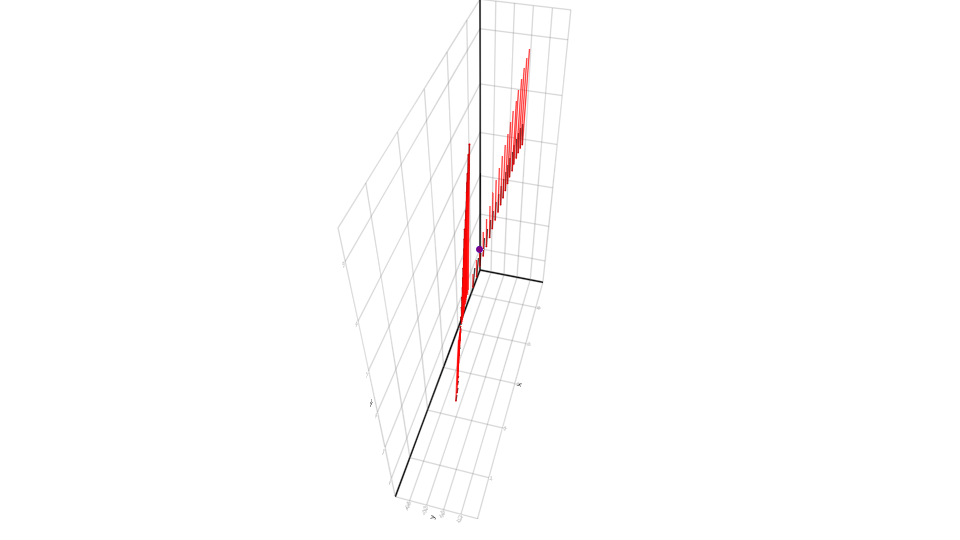

In [126]:
axis = mean(mapslices(x -> normalize_sign(normalize(cross(es[trange,1], x))), es[trange,2:end], dims=1), dims=2)[:]
@display mapslices(x -> normalize_sign(normalize(cross(es[trange,1], x))), es[trange,2:end], dims=1)
@display axis .- mapslices(x -> normalize_sign(normalize(cross(es[trange,1], x))), es[trange,2:end], dims=1)

# Try to fit the rotations
es = reshape(Q[:,8], 9, :)
function cost(x)
    c = x[1:3]
    s = x[4]
    #a = x[4:6]/norm(x[4:6])
    #a = [x[4], x[5], sqrt(1 - x[4]^2.0 - x[5]^2.0)]
    sum(sum(map(i -> (cross(poses[trange,i] .- c, axis) .- s * es[trange,i]) .^ 2.0, 1:l)))
end
function min_dot(c, es)
    sum(map(i -> dot(poses[trange,i] .- c, es[trange,i]) ^ 2.0, 1:l))
end
x0 = [center[1], center[2], center[3], 1.0]#, 0, 1, 0]
solution = optimize(cost, x0, LBFGS(), autodiff=:forward, Optim.Options(g_tol = 1e-14))
minsol = Optim.minimizer(solution)
#display(minsol)
center_ = minsol[1:3]
# minsol[4:6] ./= norm(minsol[4:6])

s = Scene()
scatter!(s, poses[4,:], poses[5,:], poses[6,:], color=:red, markersize=:0.02, transparency=true)
scatter!(s, [center[1]], [center[2]], [center[3]], trasparency=true, color=:blue)
scatter!(s, [minsol[1]], [minsol[2]], [minsol[3]], trasparency=true, color=:purple)
draw_diff!(s, poses[trange,:], es[trange,:], 5.0)
rot = linear_rotation(axis, center)
draw_diff!(s, poses[trange,:], rot[trange,:], 1.0, color=:red)

Q_ = reshape(reshape(Q, 9, :, 441)[trange,:,1:7], :, 7)
display(Q_)
v = rot[trange,:][:]
@show norm(v - Q_ * Q_' * v)

display(dot(rot[trange,:][:], es[trange,:][:]))

display("Solution")
display("Old center")
display(center)
display("Dot of rot")
display(min_dot(center_, rot))
display("Dot of es")
display(min_dot(center, es))
display(min_dot(center_, es))
display(solution)
s

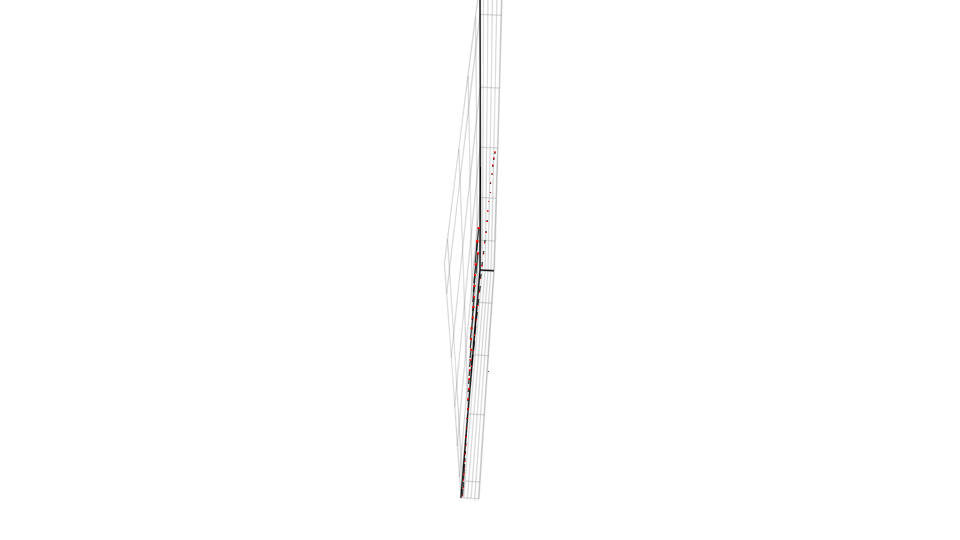

In [50]:
s = zeros(9, l)
s[1:3,:] .= poses .- c
m = hcat(x[1:3,:][:],
         y[1:3,:][:],
         z[1:3,:][:],
         s[1:3,:][:],
         x_rot[1:3,:][:],
         y_rot[1:3,:][:],
         z_rot[1:3,:][:],
         es[1:3,:][:]
        )
Q,R = qr(m)
rot = rotations(normalize(rand(3)), c)[1:3,:]
norm((I - Q * Q') * rot[:])
R
s = Scene()
draw_diff!(s, poses, reshape(Q[:,8], 3, :), 1)
scatter!(s, poses[1,:], poses[2,:], poses[3,:], color=:red, markersize=:0.02, transparency=true)

# QT JTJ Q == 0?
# JTJ * Q == 0?

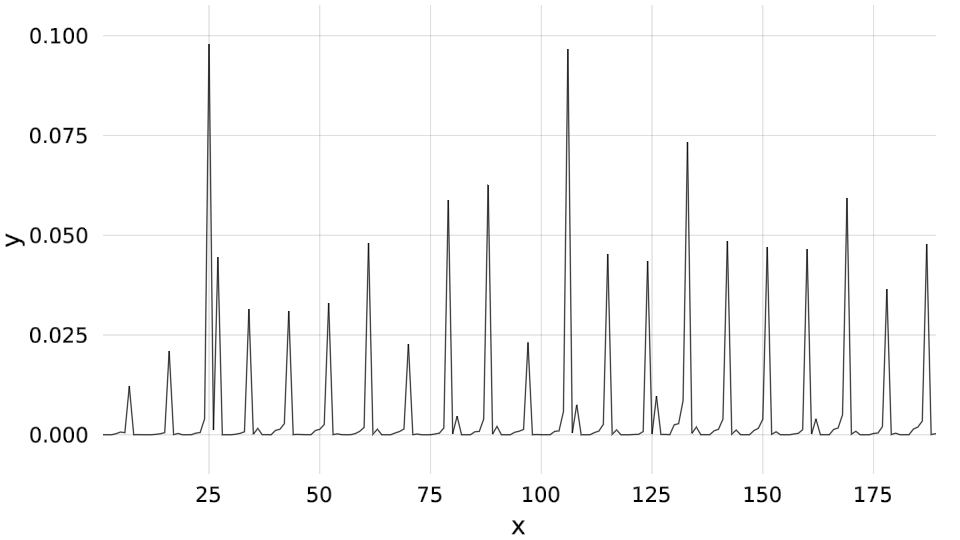

In [12]:
lines(Array(S[1][diagind(S[1])][:]) .* dscale[1][1:l*9])

This eigen mode looks like every point is translating in the same direction and rotating around the same axis.

In [13]:
extrema(mapslices(norm, reshape(eigs[1][1][:,end], 9, :)[4:6,:], dims=1))

(0.00018314022989495576, 0.0001969857134957194)

In [14]:
mapslices(norm, reshape(eigs[1][1][:,end-6], 9, :), dims=2)

9×1 Array{Float64,2}:
 4.3628438536507386e-7 
 1.7850844847319748e-5 
 1.1645163265952543e-6 
 8.930177131981236e-5  
 3.6019910305022024e-5 
 0.00024318610703329688
 2.2053699578323966e-12
 7.291108763834363e-15 
 2.1243206363251342e-13

R = 

8×8 Array{Float64,2}:
 -7.0   0.0   0.0   0.0     0.0          …  -6.59195e-17  -5.94072e-5 
  0.0  -7.0   0.0   0.0     3.33067e-16     -1.55431e-15   0.00216192 
  0.0   0.0  -7.0   0.0     6.59195e-17      0.0           0.00120955 
  0.0   0.0   0.0  12.2251  1.11619         -0.108421      0.0013119  
  0.0   0.0   0.0   0.0     9.36565          0.091631     -0.000257819
  0.0   0.0   0.0   0.0     0.0          …  -0.21128      -0.000186335
  0.0   0.0   0.0   0.0     0.0             -9.69968      -0.00278618 
  0.0   0.0   0.0   0.0     0.0              0.0          -0.00729748 

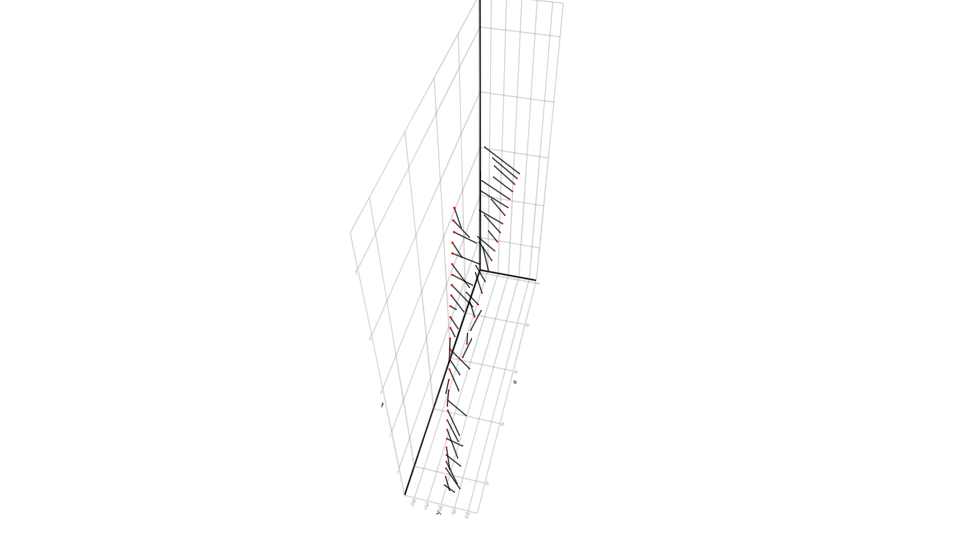

In [174]:
# Unscaled JtJ without diagonal
ev = h5read("../sba_multigrid/ladybug-49-H-smallest-0.h5", "/")["eigenvector1"]
anullspace = reshape(ev[1:length(ba.cameras)*9], 9, :)
m = hcat(x_trans[:],
         y_trans[:],
         z_trans[:],
         scaling[:],
         x_rot[:],
         y_rot[:],
         z_rot[:],
         reshape(anullspace, 9*l, :)
        )

Q,R = qr(m)
ev = Q[:,8]

@display R

s = Scene()
draw_diff!(s, poses[trange,:], reshape(ev, 9, :)[trange,:], 5.0, color=:black)
scatter!(s, poses[4,:], poses[5,:], poses[6,:], color=:red, markersize=:0.02, transparency=true)

R = 

8×8 Array{Float64,2}:
 -7.0   0.0   0.0   0.0     0.0          …  -6.59195e-17  -0.114487  
  0.0  -7.0   0.0   0.0     3.33067e-16     -1.55431e-15   0.00375756
  0.0   0.0  -7.0   0.0     6.59195e-17      0.0           0.0448701 
  0.0   0.0   0.0  12.2251  1.11619         -0.108421     -0.0688248 
  0.0   0.0   0.0   0.0     9.36565          0.091631     -0.257748  
  0.0   0.0   0.0   0.0     0.0          …  -0.21128      -0.183531  
  0.0   0.0   0.0   0.0     0.0             -9.69968      -0.07986   
  0.0   0.0   0.0   0.0     0.0              0.0           0.934684  

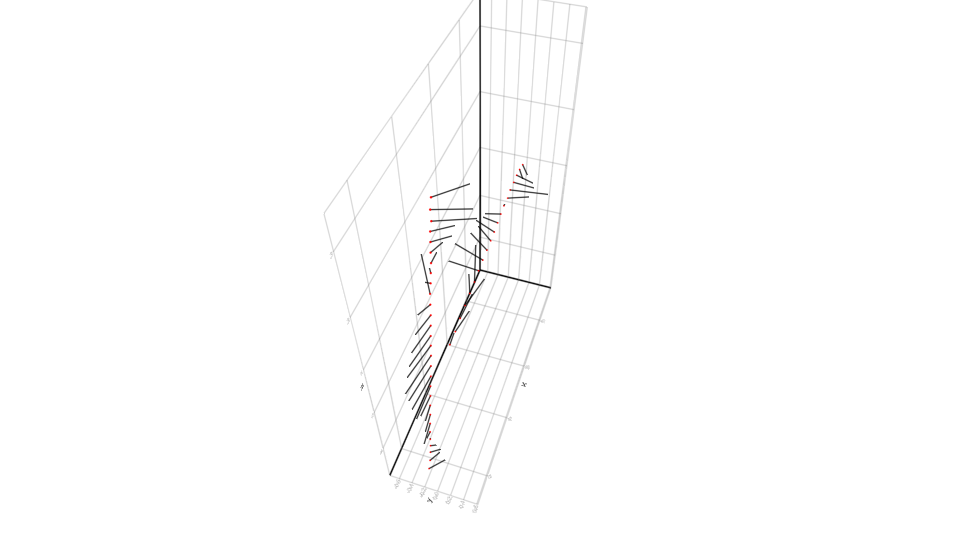

In [191]:
# Scaled S with diagonal
ev = h5read("../sba_multigrid/ladybug-49-scaled-S-smallest-0.h5", "/")["eigenvector30"]
anullspace = reshape(ev[1:length(ba.cameras)*9], 9, :)
m = hcat(nullspace_matrix(poses), reshape(anullspace, 9*l, :))

Q,R = qr(m)
ev = Q[:,8]

@display R

s = Scene()
draw_diff!(s, poses[trange,:], reshape(ev, 9, :)[trange,:], 5.0, color=:black)
scatter!(s, poses[4,:], poses[5,:], poses[6,:], color=:red, markersize=:0.02, transparency=true)

poses_dubrovnik = 

9×16 Array{Float64,2}:
   -0.016944        0.0150497    …    -0.523028        0.0511486  
    0.0111718      -0.185046          -0.0974229       0.00487881 
    0.00246435     -0.292784           0.0257498       0.103065   
    0.73031        -1.05905            5.98514         0.306505   
   -0.264908       -0.0360179         -0.592805       -0.0420219  
   -1.71279        -1.57203      …    -2.38068        -1.33057    
 1430.03         1432.14            1563.92         1918.25       
   -7.55728e-8     -7.31719e-8        -4.17664e-8     -6.03782e-9 
    3.23776e-14     3.17594e-14       -3.13007e-15    -5.43546e-15

R = 

8×8 Array{Float64,2}:
 -4.0   0.0   0.0    0.0      0.0          …   -4.996e-16     0.250257  
  0.0  -4.0   0.0    0.0     -2.22045e-16       5.55112e-16  -0.0220554 
  0.0   0.0  -4.0    0.0      2.22045e-16       0.0           0.092045  
  0.0   0.0   0.0  -20.2548  -0.193156         -0.0175793     0.133175  
  0.0   0.0   0.0    0.0     14.9901            5.2201       -0.00791652
  0.0   0.0   0.0    0.0      0.0          …   -8.30311      -0.0122213 
  0.0   0.0   0.0    0.0      0.0             -16.3348        0.147732  
  0.0   0.0   0.0    0.0      0.0               0.0           0.942677  

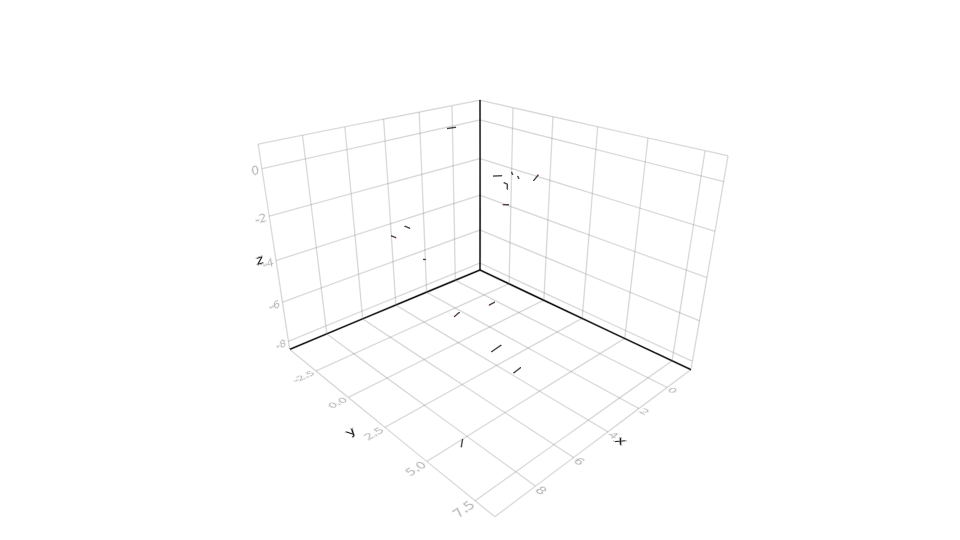

In [210]:
# Scaled S with diagonal
l = length(ba_dubrovnik.cameras)
ev = h5read("../sba_multigrid/dubrovnik-16-scaled-S-smallest-0.h5", "/")["eigenvector3"]
anullspace = reshape(ev[1:length(ba_dubrovnik.cameras)*9], 9, :)
@display poses_dubrovnik
m = hcat(nullspace_matrix(poses_dubrovnik), reshape(anullspace, 9*l, :))

Q,R = qr(m)
ev = Q[:,8]

@display R

s = Scene()
draw_diff!(s, poses_dubrovnik[trange,:], reshape(ev, 9, :)[trange,:], 5.0, color=:black)
scatter!(s, poses_dubrovnik[4,:], poses_dubrovnik[5,:], poses_dubrovnik[6,:], color=:red, markersize=:0.02, transparency=true)

R = 

8×8 Array{Float64,2}:
 -4.0   0.0   0.0    0.0      0.0          …   -4.996e-16     0.00114654
  0.0  -4.0   0.0    0.0     -2.22045e-16       5.55112e-16  -0.0133966 
  0.0   0.0  -4.0    0.0      2.22045e-16       0.0           0.0124039 
  0.0   0.0   0.0  -20.2548  -0.193156         -0.0175793    -2.14751e-5
  0.0   0.0   0.0    0.0     14.9901            5.2201        0.0004826 
  0.0   0.0   0.0    0.0      0.0          …   -8.30311      -0.00356918
  0.0   0.0   0.0    0.0      0.0             -16.3348       -0.00169876
  0.0   0.0   0.0    0.0      0.0               0.0          -0.00747414

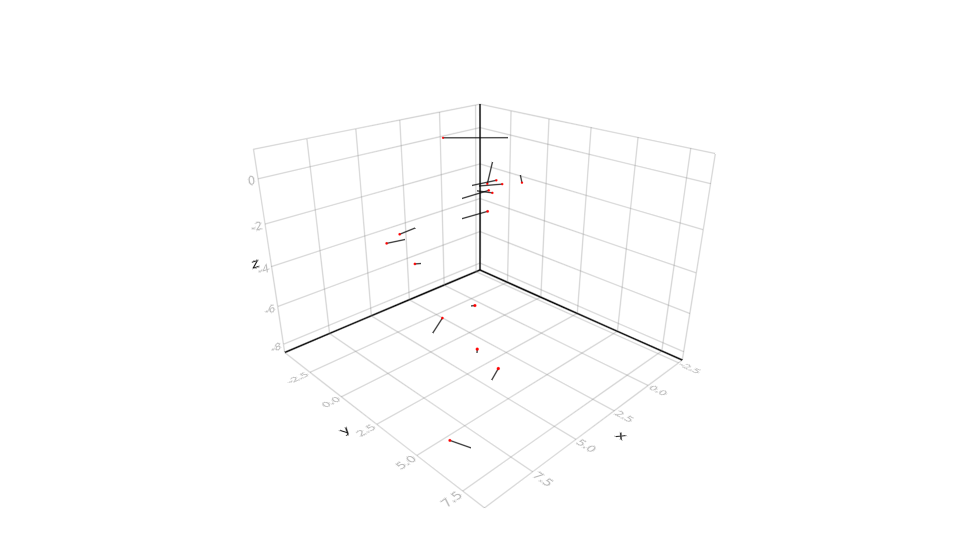

In [219]:
# JtJ without diagonal
l = length(ba_dubrovnik.cameras)
ev = h5read("../sba_multigrid/dubrovnik-16-H-smallest-0.h5", "/")["eigenvector2"]
anullspace = reshape(ev[1:length(ba_dubrovnik.cameras)*9], 9, :)
m = hcat(nullspace_matrix(poses_dubrovnik), reshape(anullspace, 9*l, :))

Q,R = qr(m)
ev = Q[:,8]

@display R

s = Scene()
draw_diff!(s, poses_dubrovnik[trange,:], reshape(ev, 9, :)[trange,:], 5.0, color=:black)
scatter!(s, poses_dubrovnik[4,:], poses_dubrovnik[5,:], poses_dubrovnik[6,:], color=:red, markersize=:0.1, transparency=true)

In [253]:
J = readPETSc("../ba-tao/ladybug-49-J.petsc")
JtJ = J' * J
JtJ = JtJ[1:49*9,1:49*9] # get camera portion

poses = reshape(readPETSc("../ba-tao/ladybug-49-solution.petsc")[1][1:49*9], 9, :)
rot_vec = linear_rotation(poses, [0, 1, 0], mapslices(mean, poses, dims=1))

l = 49
rinds = (((1:l*9) .- 1) .% 9) .<= 3
tinds = 4 .<= (((1:l*9) .- 1) .% 9) .<= 6
iinds = 7 .<= (((1:l*9) .- 1) .% 9) .<= 9

@display J[:,findall(tinds)]
norm(J[:,findall(tinds)] * rot_vec[4:6,:][:])

J[:, findall(tinds)] = 

63686×147 SparseMatrixCSC{Float64,Int32} with 191058 stored entries:
  [1    ,     1]  =  0.000204691
  [2    ,     1]  =  551.177
  [3    ,     1]  =  -2.26985e-6
  [4    ,     1]  =  69.9024
  [5    ,     1]  =  2.68704e-6
  [6    ,     1]  =  109.769
  [7    ,     1]  =  -1.8445e-6
  [8    ,     1]  =  70.2494
  [9    ,     1]  =  -3.00054e-6
  [10   ,     1]  =  70.5036
  [11   ,     1]  =  5.6891e-7
  [12   ,     1]  =  67.3723
  ⋮
  [63675,   147]  =  0.287512
  [63676,   147]  =  0.0525562
  [63677,   147]  =  0.338104
  [63678,   147]  =  0.0480798
  [63679,   147]  =  0.916038
  [63680,   147]  =  -0.0485677
  [63681,   147]  =  0.933049
  [63682,   147]  =  -0.0487247
  [63683,   147]  =  0.275416
  [63684,   147]  =  0.0908751
  [63685,   147]  =  0.500638
  [63686,   147]  =  0.0641351

4.475719064040286e6